In [16]:
import numpy as np
import matplotlib
import json
import pandas as pd
import os
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk import ngrams
from transformers import RobertaTokenizerFast

In [42]:
bbpe_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def get_num_tokens(text):
    return len(word_tokenize(text))

def get_num_bbpe_tokens(text):
    return len(bbpe_tokenizer(text)["input_ids"])

def freqs_to_df(d, sort=True):
    return pd.DataFrame.from_dict(d, orient="index", columns=["Count"]).sort_values("Count", ascending=False)


In [49]:
# Build table for generating dataset statistics
splits = ["train", "valid_seen", "valid_unseen"]
task_fields = ["task_type", "focus_object", "base_object", "dest_object", "scene"]
data_path = "../tars/alfred/data/json_2.1.0"
stats_dict = defaultdict(lambda: [])
action_freqs = defaultdict(lambda: defaultdict(lambda: 0))
bigram_freqs = {"task": defaultdict(lambda: 0), "steps": defaultdict(lambda: 0)}
trigram_freqs = {"task": defaultdict(lambda: 0), "steps": defaultdict(lambda: 0)}

for split in splits:
    task_dirs = os.listdir("{}/{}".format(data_path, split))
    for i in tqdm(range(len(task_dirs))):
        task_dir = task_dirs[i]
        task_values = task_dir.split("-")
        for trial_dir in os.listdir("{}/{}/{}".format(data_path, split, task_dir)):
            stats_dict["split"].append(split)
            stats_dict["task_id"].append(trial_dir)

            for j, field in enumerate(task_fields):
                stats_dict[field].append(task_values[j])

            traj_data_file = open("{}/{}/{}/{}/traj_data.json".format(data_path, split, task_dir, trial_dir))
            traj_data = json.load(traj_data_file)
            num_steps_list = []
            num_step_tokens_list = []
            num_task_tokens_list = []
            num_step_bbpe_tokens_list = []
            num_task_bbpe_tokens_list = []

            for directive in traj_data["turk_annotations"]["anns"]:
                task_desc_toks = word_tokenize(directive["task_desc"])
                num_task_tokens_list.append(len(task_desc_toks))
                for bigram in ngrams(task_desc_toks, 2):
                    bigram_freqs["task"][bigram] += 1
                for trigram in ngrams(task_desc_toks, 3):
                    trigram_freqs["task"][trigram] += 1
                num_steps_list.append(len(directive["high_descs"]))
                total_steps_toks = 0
                for desc in directive["high_descs"]:
                    desc_toks = word_tokenize(desc)
                    total_steps_toks += len(desc_toks)
                    for bigram in ngrams(desc_toks, 2):
                        bigram_freqs["steps"][bigram] += 1
                    for trigram in ngrams(desc_toks, 3):
                        trigram_freqs["steps"][trigram] += 1
                num_step_tokens_list.append(total_steps_toks)

                num_step_bbpe_tokens_list.append(sum([get_num_bbpe_tokens(desc) for desc in directive["high_descs"]]))
                num_task_bbpe_tokens_list.append(get_num_bbpe_tokens(directive["task_desc"]))

            stats_dict["steps"].append(np.mean(num_steps_list))
            stats_dict["total_steps_toks"].append(np.mean(num_step_tokens_list))
            stats_dict["total_steps_bbpe_toks"].append(np.mean(num_step_bbpe_tokens_list))
            stats_dict["task_toks"].append(np.mean(num_task_tokens_list))
            stats_dict["task_bbpe_toks"].append(np.mean(num_task_bbpe_tokens_list))
            stats_dict["images"].append(len(traj_data["images"]))
            stats_dict["actions"].append(len(traj_data["plan"]["low_actions"]))

            nav_count = 0
            interact_count = 0
            mask_cov_per_ac = 0

            for action in traj_data["plan"]["low_actions"]:
                action_freqs[split][action["api_action"]["action"]] += 1
                args = action['discrete_action']['args']
                if "mask" in args:
                    interact_count += 1
                    mask_cov_per_ac += sum([l for _, l in args['mask']])
                else:
                    nav_count += 1

            stats_dict["mask_coverage_per_action"].append(mask_cov_per_ac / (300 * 300 * interact_count))
            stats_dict["nav_actions"].append(nav_count)
            stats_dict["interact_actions"].append(interact_count)


stats_df = pd.DataFrame(stats_dict)
action_df = pd.DataFrame(action_freqs)
task_bigram_df = freqs_to_df(bigram_freqs["task"])
steps_bigram_df = freqs_to_df(bigram_freqs["steps"])
task_trigram_df = freqs_to_df(trigram_freqs["task"])
steps_trigram_df = freqs_to_df(trigram_freqs["steps"])

100%|██████████| 85/85 [00:02<00:00, 34.35it/s]


In [53]:
# Derive some additional columns
stats_df["toks/step"] = stats_df["total_steps_toks"] / stats_df["steps"]
stats_df["bbpe_toks/step"] = stats_df["total_steps_bbpe_toks"] / stats_df["steps"]
stats_df["actions/step"] = stats_df["actions"] / stats_df["steps"]
stats_df["images/action"] = stats_df["images"] / stats_df["actions"]
stats_df["nav/interact"] = stats_df["nav_actions"] / stats_df["interact_actions"]

stats_df = stats_df.round(2)

In [54]:
stats_df

,split,task_id,task_type,focus_object,base_object,dest_object,scene,steps,total_steps_toks,total_steps_bbpe_toks,...,images,actions,mask_coverage_per_action,nav_actions,interact_actions,toks/step,bbpe_toks/step,actions/step,images/action,nav/interact
0,train,trial_T20190908_081542_564499,pick_and_place_with_movable_recep,ButterKnife,Pan,CounterTop,8,7.0,84.33,102.33,...,222,40,0.06,36,4,12.05,14.62,5.71,5.55,9.00
1,train,trial_T20190908_081608_404049,pick_and_place_with_movable_recep,ButterKnife,Pan,CounterTop,8,7.0,76.67,93.00,...,180,28,0.06,24,4,10.95,13.29,4.00,6.43,6.00
2,train,trial_T20190908_081632_840019,pick_and_place_with_movable_recep,ButterKnife,Pan,CounterTop,8,7.0,79.33,93.67,...,213,40,0.07,36,4,11.33,13.38,5.71,5.32,9.00
3,train,trial_T20190907_181551_510121,pick_cool_then_place_in_recep,Cup,None,Shelf,1,6.0,95.33,107.67,...,378,79,0.43,71,8,15.89,17.94,13.17,4.78,8.88
4,train,trial_T20190907_181654_244229,pick_cool_then_place_in_recep,Cup,None,Shelf,1,6.0,69.33,81.67,...,314,56,0.44,48,8,11.56,13.61,9.33,5.61,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7075,valid_unseen,trial_T20190906_180922_517529,look_at_obj_in_light,Laptop,None,FloorLamp,219,4.0,43.17,53.00,...,153,25,0.11,22,3,10.79,13.25,6.25,6.12,7.33
7076,valid_unseen,trial_T20190906_181009_893506,look_at_obj_in_light,Laptop,None,FloorLamp,219,4.0,39.67,49.17,...,174,31,0.11,28,3,9.92,12.29,7.75,5.61,9.33
7077,valid_unseen,trial_T20190907_080730_211959,pick_clean_then_place_in_recep,Spatula,None,Drawer,10,6.0,75.67,93.67,...,266,41,0.05,33,8,12.61,15.61,6.83,6.49,4.12
7078,valid_unseen,trial_T20190907_080800_275989,pick_clean_then_place_in_recep,Spatula,None,Drawer,10,6.0,86.00,102.67,...,274,45,0.05,37,8,14.33,17.11,7.50,6.09,4.62


In [7]:
action_df

,train,valid_seen,valid_unseen
LookDown,19948,730,776
RotateLeft,27901,1063,1011
MoveAhead,195054,7540,6877
RotateRight,29447,1122,992
OpenObject,6568,257,291
PickupObject,12316,470,459
CloseObject,6637,259,294
PutObject,11569,438,404
LookUp,12566,489,632
ToggleObjectOn,2524,100,132


In [51]:
task_trigram_df[:20]

,Count
"(on, the, counter)",1150
"(the, sink, .)",1142
"(it, on, the)",1022
"(on, the, table)",1022
"(in, the, sink)",978
"(the, counter, .)",815
"(in, the, microwave)",815
"(in, the, fridge)",790
"(it, in, the)",772
"(the, table, .)",746


In [52]:
steps_trigram_df[:20]

,Count
"(Pick, up, the)",18425
"(Turn, around, and)",11767
"(to, the, left)",11126
"(to, the, right)",11084
"(walk, to, the)",10767
"(the, sink, .)",9361
"(to, face, the)",9064
"(and, walk, to)",8722
"(go, to, the)",8616
"(in, front, of)",6828


In [58]:
# Plot frequency of a categorical field. Useful for task_type and maybe objects.
def plot_freq(col, **kwargs):
    splits = ["train", "valid_seen", "valid_unseen"]
    freq_cols = {split:stats_df[stats_df["split"] == split][col].value_counts(normalize=True) for split in splits}
    pd.concat(freq_cols, axis=1).plot.bar(xlabel=col, ylabel="Relative Frequency", **kwargs)

# Plot histogram of a quantitative field. 
def plot_hist(col, **kwargs):
    splits = ["train", "valid_seen", "valid_unseen"]
    axes = stats_df.hist(col, by="split", sharex=True, **kwargs)
    for ax in axes.reshape(-1):
        ax.tick_params(axis="x", which="both", labelbottom=True)
        ax.set_xlabel(col, visible=True)
        ax.set_ylabel("Frequency")

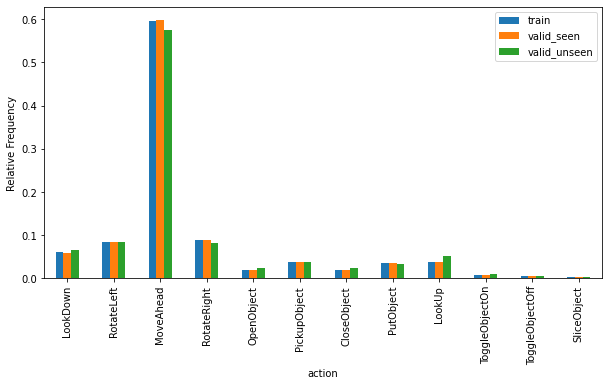

In [8]:
action_plot = action_df.div(action_df.sum(axis=0)).plot.bar(figsize=(10, 5), xlabel="action", ylabel="Relative Frequency")

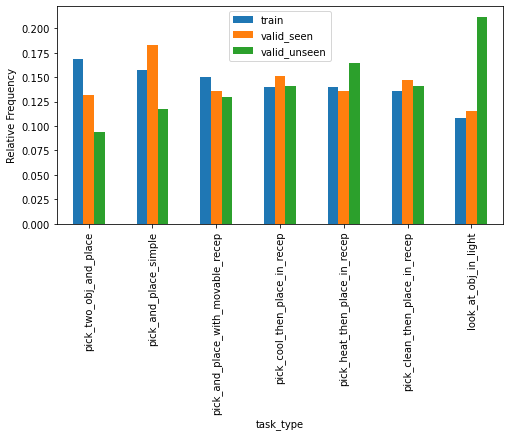

In [10]:
plot_freq("task_type", figsize=(8, 4))

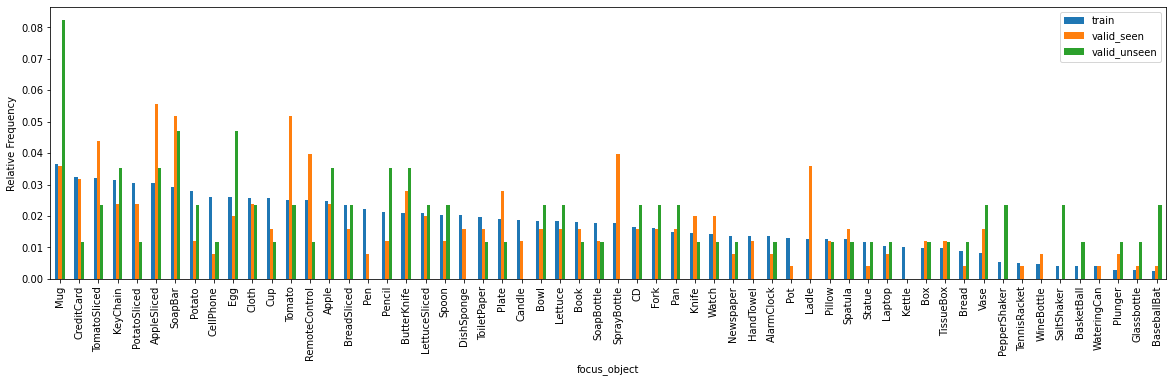

In [11]:
plot_freq("focus_object", figsize=(20, 5))

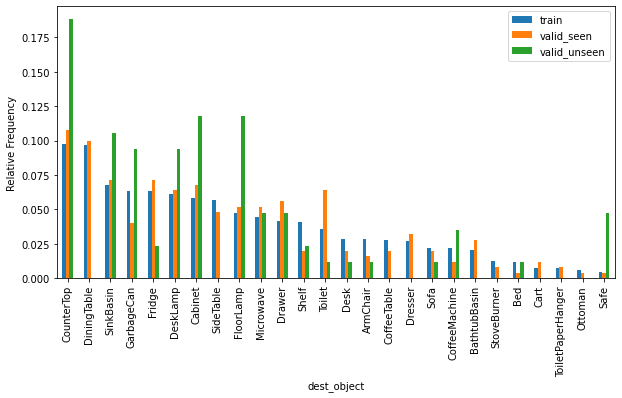

In [12]:
plot_freq("dest_object", figsize=(10, 5))

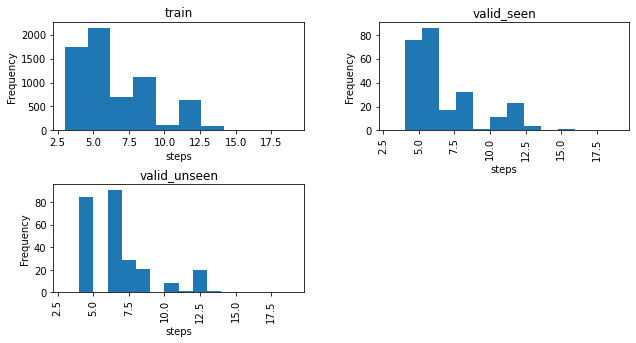

In [59]:
plot_hist("steps", figsize=(10, 5))

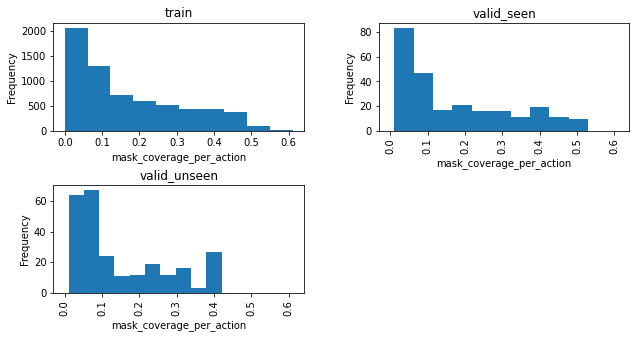

In [16]:
plot_hist("mask_coverage_per_action", figsize=(10, 5))

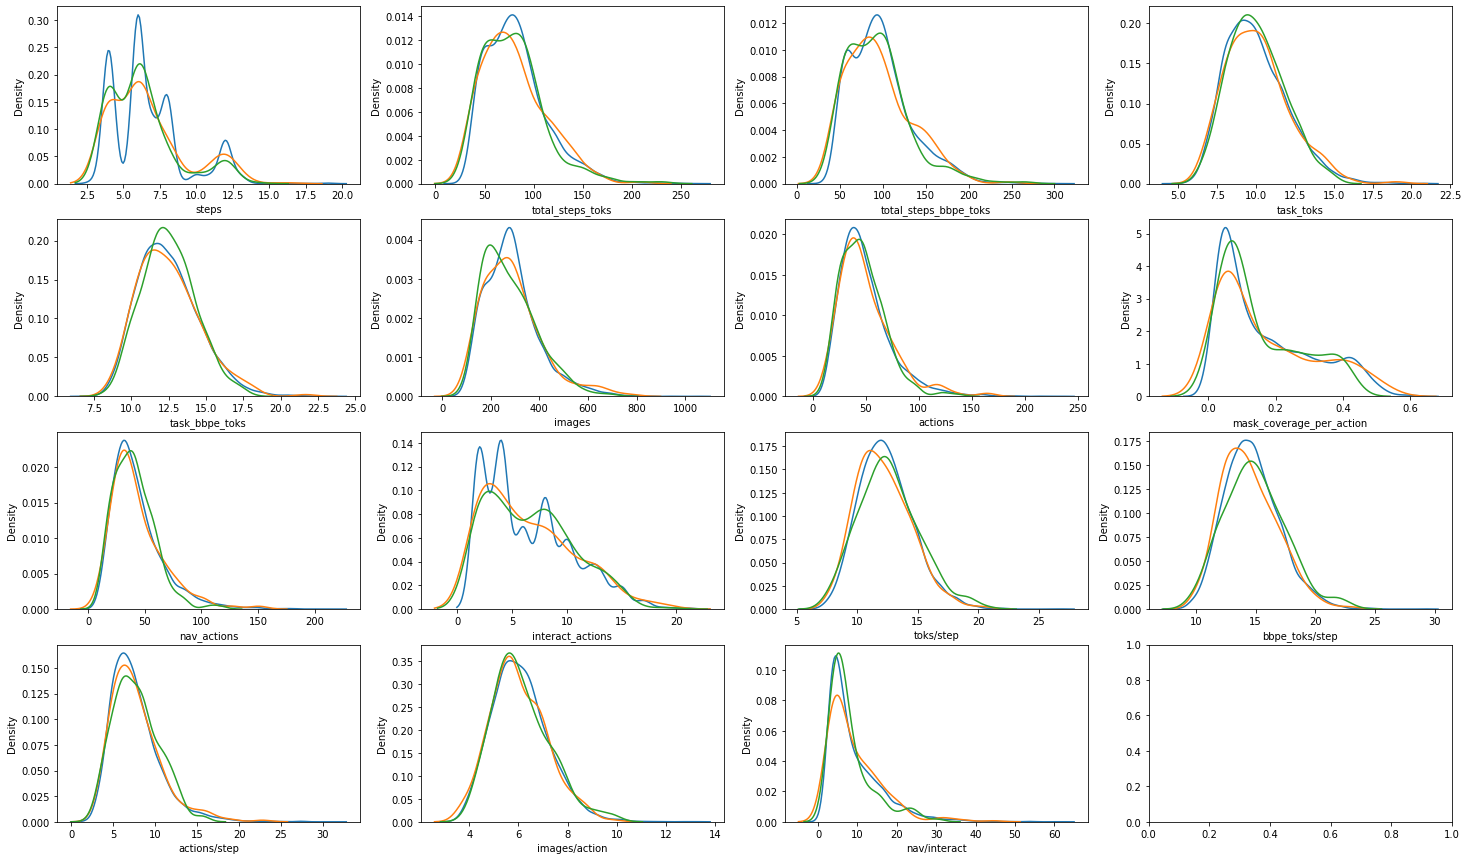

In [56]:
# KDE of quantitative fields
# Inspired by https://stackoverflow.com/questions/46045750/python-distplot-with-multiple-distributions

cs = [c for c in stats_df.columns if stats_df[c].dtype != 'O']
splits = stats_df['split'].unique()
df = stats_df[['split'] + cs].melt(['split'], var_name='cols', value_name='vals')
num_cols = 4
num_rows = math.ceil(len(cs) / num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 15))

col = 0
for r in range(len(axs)):
    for c in range(len(axs[r])):
        if col >= len(cs):
            break
        for s in splits:
            sns.distplot(stats_df[stats_df['split'] == s][cs[col]], hist=False, rug=False, ax=axs[r][c])
        col += 1


In [55]:
# Mean of quantitative fields
stats_df.groupby('split').mean().round(2)

,steps,total_steps_toks,total_steps_bbpe_toks,task_toks,task_bbpe_toks,images,actions,mask_coverage_per_action,nav_actions,interact_actions,toks/step,bbpe_toks/step,actions/step,images/action,nav/interact
split,,,,,,,,,,,,,,,
train,6.68,81.88,97.16,10.02,12.48,286.75,49.78,0.17,43.34,6.44,12.39,14.69,7.60,6.08,9.19
valid_seen,6.64,80.20,95.29,10.09,12.52,287.24,50.12,0.17,43.60,6.52,12.18,14.45,7.72,6.02,9.25
valid_unseen,6.27,78.73,93.16,10.04,12.52,277.72,46.98,0.15,40.35,6.63,12.63,14.94,7.72,6.12,8.13
